#### Whats in the notebook?
    1. Visualization using mapclassify: With the choropleth map, we can see binned price ranges, but that does not give us any statistics we can determine if there is spatial autocorrelation (Positive or Negative, or even where the hotspots and coldspots are. That is what we do next.
    2. Spatial Autocorrelation: The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.
    3. Univariate/Multivariaate analysis
    4. hotspots and cold spots Moral i statistics

#### Libraries we gonna work on:
    Libpysal: wiights for spatial weights


more on geopandas using the berlin distric dataset

Dataset: https://lab.technologiestiftung-berlin.de/projects/spatial-units/en/

We gonna talk about visualization and methods of exploratory spatial data analuysis usinf univariate and multivariate statistical test for sacial clustering

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure. For thsi we can use PySAL

In [8]:
import numpy as no
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
import geoplot

import mapclassify as mc
import libpysal as lp
import rasterio as rio

from pysal.explore import  esda
from esda.moran import Moran, Moran_Local

In [33]:
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster


In [10]:
countries = gpd.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = gpd.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = gpd.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

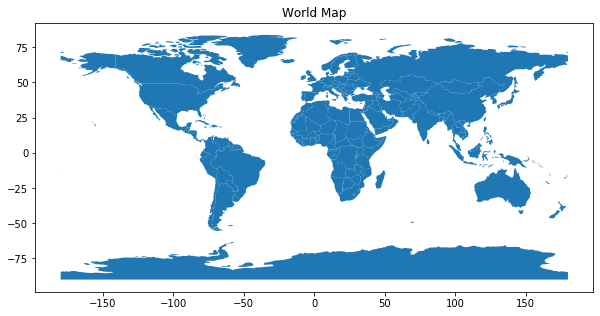

In [11]:
countries.plot(figsize=(10, 10))
plt.title('World Map')
plt.show()

In [12]:
df = gpd.read_file('data/berlin-districts.geojson')

In [13]:
df.head(5)

,district,district_group,median_price,geometry
0,Blankenfelde/Niederschönhausen,Pankow,37.5,"MULTIPOLYGON (((1493006.880 6912074.798, 14929..."
1,Helmholtzplatz,Pankow,58.0,"MULTIPOLYGON (((1493245.549 6900059.696, 14932..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,50.0,"MULTIPOLYGON (((1481381.452 6885170.698, 14813..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,99.0,"MULTIPOLYGON (((1526159.829 6872101.044, 15261..."
4,Müggelheim,Treptow - Köpenick,25.0,"MULTIPOLYGON (((1529265.086 6874326.842, 15292..."


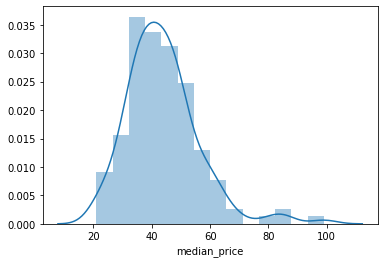

In [14]:
sns.distplot(df['median_price'])

In [15]:
df.describe()

,median_price
count,138.000000
mean,43.766884
std,12.498125
min,21.000000
25%,35.000000
50%,42.000000
75%,50.000000
max,99.000000


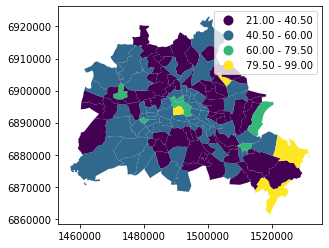

In [16]:
# scheme can be quantiles, equal intervals, median_price
# we can get more schemes from import mapclassify as mc
df.plot(column='median_price', scheme='equal_interval', k=4, legend= True)

In [17]:
mc.CLASSIFIERS

('BoxPlot',
 'EqualInterval',
 'FisherJenks',
 'FisherJenksSampled',
 'HeadTailBreaks',
 'JenksCaspall',
 'JenksCaspallForced',
 'JenksCaspallSampled',
 'MaxP',
 'MaximumBreaks',
 'NaturalBreaks',
 'Quantiles',
 'Percentiles',
 'StdMean',
 'UserDefined')

In [18]:
EI4 = mc.EqualInterval(df['median_price'], k=4)


In [19]:
EI4

EqualInterval         

   Interval      Count
----------------------
[21.00, 40.50] |    64
(40.50, 60.00] |    64
(60.00, 79.50] |     6
(79.50, 99.00] |     4

In [20]:
q5 = mc.Quantiles(df['median_price'], k=5)
q5

Quantiles             

   Interval      Count
----------------------
[21.00, 35.00] |    39
(35.00, 40.00] |    23
(40.00, 45.00] |    29
(45.00, 50.00] |    22
(50.00, 99.00] |    25

### selecting classification based on fit
Choropleth mapping can be used for different purposes. The most common is to select a classification that provides a balance between maximizing the differences between observations in each bin, and minimizing the intra-bin heterogeneity.

The classifiers in PySAL have underlying measures of fit for this purpose, but it is important to keep in mind these should only be used for classifiers with the same number of classes. One

One such measure is the the absolute deviation around class
medians (ADCM). Let's use this to compare all k=5 classifiers:


In [21]:
y = df['median_price']
q5 = mc.Quantiles(y, k=5)
ei5 = mc.EqualInterval(y, k=5)
mb5 = mc.MaximumBreaks(y, k=5)
fj5 = mc.FisherJenks(y, k=5)
fits = [c.adcm for c in [q5, ei5, mb5, fj5]]
fits

[403.67, 492.83, 1045.83, 368.83]

In [22]:
std = mc.StdMean(y)
std

StdMean               

   Interval      Count
----------------------
( -inf, 18.77] |     0
(18.77, 31.27] |    17
(31.27, 56.27] |   103
(56.27, 68.76] |    13
(68.76, 99.00] |     5

In [23]:
bp = mc.BoxPlot(y)
bp

BoxPlot               

   Interval      Count
----------------------
( -inf, 12.50] |     0
(12.50, 35.00] |    39
(35.00, 42.00] |    31
(42.00, 50.00] |    43
(50.00, 72.50] |    21
(72.50, 99.00] |     4

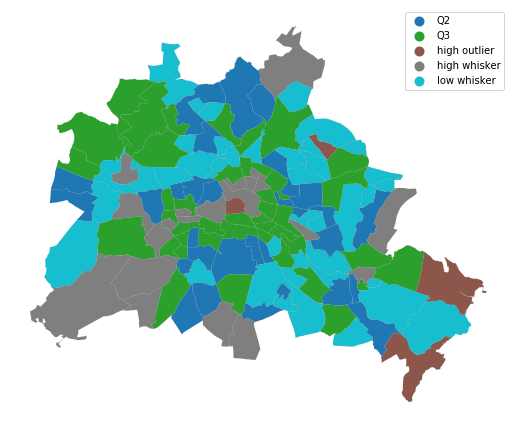

In [24]:
label = ['low outlier', 'low whisker', 'Q2', 'Q3',
        'high whisker', 'high outlier']

bpl = [label[b] for b in bp.yb]
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=bpl).plot(column='cl', categorical=True,
                      k=5, linewidth=0.1, ax=ax,
                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

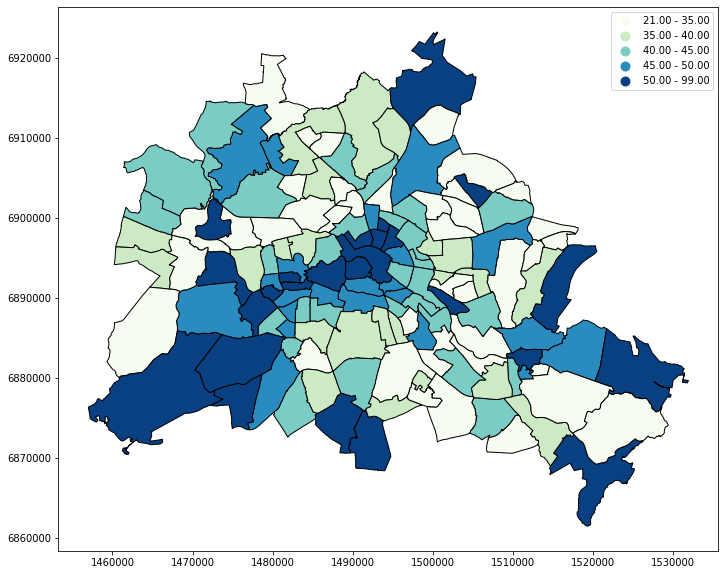

In [25]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
df.plot(column='median_price', scheme='Quantiles', 
        k=5, cmap='GnBu', legend=True, ax=ax, edgecolor = 'k')

Before we perform any spacial correlation, we need to determine spatial weight and spatial lag first. Spacial weights are how we determine the areas neighbourhood.

#### Spatial weights
. Spatial weights is to determine the area's neighborhood. One of the most commonly used spatial weights methods is Queen Contiguity Matrix, which we use

#### Spatial lag
. Spatial Lag is the product of spatial weights matrix for a given variable (in our case, the price). The spatial lag standardizes the rows and takes the average result of the price in each weighted neighborhood.

So the spatial weight between districts $i$ and $j$ indicates if the two are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For district $i$ the spatial lag is defined as:

$$y_i = \sum_j w_{i,j} y_j$$

The output of theis variable holds the weighed price of each neighbourhood. the quantile map for the spatial lag tends to enhance the impression of value similarity in space, it is smoother.

#### Spatial autocorrelation
it determines the overall pattern in the dataset.We are going to sue the Moran's tatistics to determine the global spatial autocorrelaiton. Uisng the statistics we get a number ranging from [-1,1] determining the positive and negative spatial autocorrelation.

Purpose is to determine if there is negative or positive spatial autocorrelation between the price of properties in neighborhoods and their locations.
But we have not detected where clusters are. Local Indicators of Spatial Association (LISA) is used to do that. LISA classifies areas into four groups: high values near to high values (HH), Low values with nearby low values (LL), Low values with high values in its neighborhood, and vice-versa.

We are going to use the Queen method of weighing for future but we are going to compare it with rook method. generally its better to use queen method over rook when we are using polygon representation. but it doesnt matter that much

In [26]:
wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'

wq_rook =  lp.weights.Rook.from_dataframe(df)
wq_rook.transform = 'r'

In [27]:
ylag = lp.weights.lag_spatial(wq, y)
ylag_rook = lp.weights.lag_spatial(wq_rook, y)

In [28]:
ylag

array([45.2       , 52.625     , 45.75      , 32.5       , 63.5       ,
       42.        , 45.625     , 44.14285714, 43.33333333, 38.75      ,
       41.5       , 50.8       , 36.6875    , 54.36363636, 54.375     ,
       38.92857143, 38.125     , 50.9       , 35.6875    , 59.66666667,
       46.875     , 46.92857143, 49.58333333, 47.25      , 53.25      ,
       40.57142857, 37.66666667, 37.14285714, 40.75      , 41.5       ,
       45.9       , 35.3       , 47.9375    , 47.33333333, 40.        ,
       44.        , 58.3       , 53.16666667, 42.166     , 43.75      ,
       51.625     , 52.3       , 50.5       , 46.91666667, 47.        ,
       38.125     , 35.33333333, 48.83333333, 46.6       , 43.125     ,
       40.805     , 41.33333333, 42.        , 45.7075    , 55.66666667,
       46.2       , 47.33333333, 50.47875   , 49.2075    , 42.92857143,
       43.4       , 40.78571429, 37.42857143, 32.75      , 45.57142857,
       51.25      , 44.        , 33.33333333, 33.25      , 42.  

In [29]:
df.columns

Index(['district', 'district_group', 'median_price', 'geometry'], dtype='object')

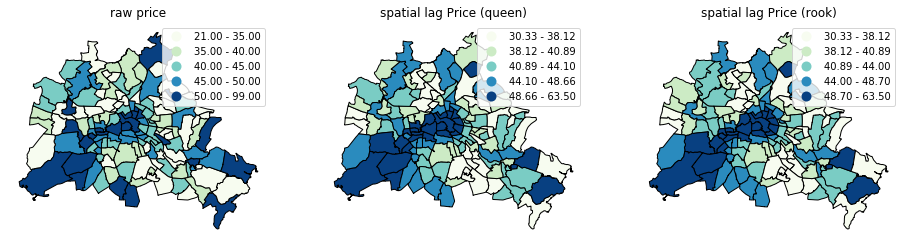

In [30]:
df['lag_price'] = ylag
df['lag_price_rook'] = ylag_rook


# next step is to compare the price
fig, ax = plt.subplots(1,3,figsize=(16,16))
df.plot(column = 'median_price', ax=ax[0], scheme= 'quantiles', k=5, cmap='GnBu', legend = True ,edgecolor = 'k')
ax[0].set_title('raw price')

df.plot(column = 'lag_price', ax=ax[1], scheme= 'quantiles', k=5, cmap='GnBu', legend = True ,edgecolor = 'k')
ax[1].set_title('spatial lag Price (queen)')

df.plot(column = 'lag_price_rook', ax=ax[2], scheme= 'quantiles', k=5, cmap='GnBu', legend = True ,edgecolor = 'k')
ax[2].set_title('spatial lag Price (rook)')


ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

####

In [31]:
moran = Moran(y,wq)
moran.I

0.09946269199744258

C:\Users\sidha\Anaconda3\lib\site-packages\splot\_viz_esda_mpl.py:132: UserWarning: `p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects
  warnings.warn('`p` is only used for plotting `esda.moran.Moran_Local`\n'


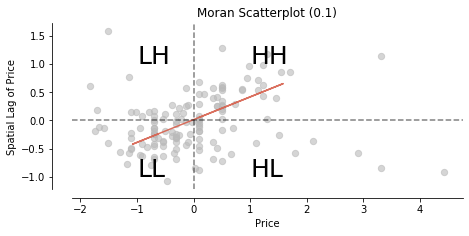

In [42]:
fig, ax = moran_scatterplot(moran, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.text(1, 1, "HH", fontsize=25)
plt.text(1, -1, "HL", fontsize=25)
plt.text(-1, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

AttributeError: 'Moran' object has no attribute 'q'

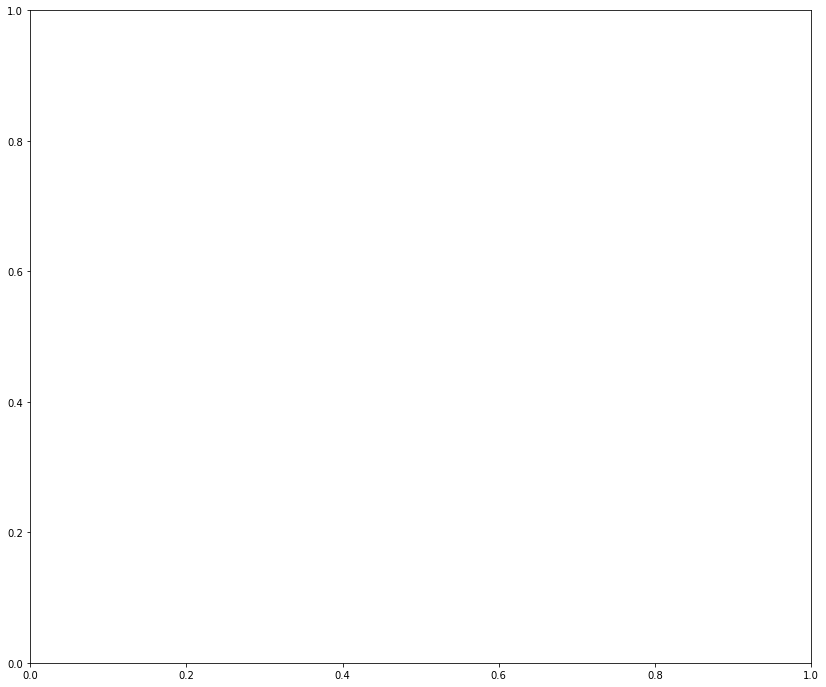

## Spatial autocorrelation

In [47]:
# In this step we are dividing aareas which are above and below mean ie black and white areas
yb = y > y.median()
labels = ["0", "1"]
yb = [labels[i] for i in yb] 
df['yb'] = yb

(1453244.2429492343, 1535626.7553124032, 6858431.787552153, 6926284.177719955)

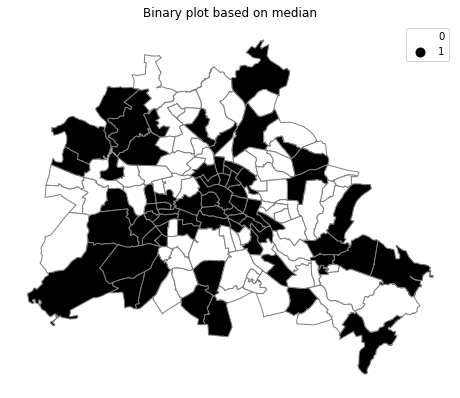

In [60]:
#ax = plt.plot(figsize=(12,10))

fig = plt.figure(figsize=(8,8))
ax = plt.gca()
df.plot(column='yb', cmap = 'binary', edgecolor='grey', legend=True, ax=ax)
ax.set_title('Binary plot based on median')
ax.axis('off')
